In [2]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [4]:
# 2. Đọc file csv và gắng index với giá Close
dxg = pd.read_csv('../DATA/DXG.csv')
qcg = pd.read_csv('../DATA/QCG.csv')
vhm = pd.read_csv('../DATA/VHM.csv')

def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
# Áp dụng hàm cho toàn bộ DataFrame
dxg = dxg['Close'].apply(remove_commas_and_convert)
qcg = qcg['Close'].apply(remove_commas_and_convert)
vhm = vhm['Close'].apply(remove_commas_and_convert)

dxg1=dxg.reset_index()['Close']
qcg1=qcg.reset_index()['Close']
vhm1=vhm.reset_index()['Close']

In [7]:
dxg1

0       18450.0
1       18250.0
2       18050.0
3       18200.0
4       17850.0
         ...   
1247    17092.0
1248    17673.2
1249    17502.2
1250    17809.9
1251    17057.8
Name: Close, Length: 1252, dtype: float64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [4]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.7 * len(dxg1))
dxg_test_size = int(0.2 * len(dxg1))
dxg_val_size = len(dxg1) - dxg_train_size - dxg_test_size
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]
dxg_val_data = dxg1[dxg_train_size+dxg_test_size:]

#QCG
qcg_train_size = int(0.7 * len(qcg1))
qcg_test_size = int(0.2 * len(qcg1))
qcg_val_size = len(qcg1) - qcg_train_size - qcg_test_size
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]
qcg_val_data = qcg1[qcg_train_size+qcg_test_size:]

#VHM
vhm_train_size = int(0.7 * len(vhm1))
vhm_test_size = int(0.2 * len(vhm1))
vhm_val_size = len(vhm1) - vhm_train_size - vhm_test_size
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]
vhm_val_data = vhm1[vhm_train_size+vhm_test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
dxg_X_val, dxg_yval = create_dataset(dxg_val_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
vhm_X_val, vhm_yval = create_dataset(vhm_val_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for 
dxg_X_train =dxg_X_train.reshape(dxg_X_train.shape[0],dxg_X_train.shape[1] , 1)
dxg_X_test = dxg_X_test.reshape(dxg_X_test.shape[0],dxg_X_test.shape[1] , 1)
dxg_X_val = dxg_X_val.reshape(dxg_X_val.shape[0],dxg_X_val.shape[1] , 1)

qcg_X_train =qcg_X_train.reshape(qcg_X_train.shape[0],qcg_X_train.shape[1] , 1)
qcg_X_test = qcg_X_test.reshape(qcg_X_test.shape[0],qcg_X_test.shape[1] , 1)
qcg_X_val = qcg_X_val.reshape(qcg_X_val.shape[0],qcg_X_val.shape[1] , 1)

vhm_X_train =vhm_X_train.reshape(vhm_X_train.shape[0],vhm_X_train.shape[1] , 1)
vhm_X_test = vhm_X_test.reshape(vhm_X_test.shape[0],vhm_X_test.shape[1] , 1)
vhm_X_val = vhm_X_val.reshape(vhm_X_val.shape[0],vhm_X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

dxg_model = Sequential()
dxg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
dxg_model.add(Dense(1))
dxg_model.compile(optimizer='adam', loss='mean_squared_error')

qcg_model = Sequential()
qcg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
qcg_model.add(Dense(1))
qcg_model.compile(optimizer='adam', loss='mean_squared_error')

vhm_model = Sequential()
vhm_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
vhm_model.add(Dense(1))
vhm_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Khang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 9. Fit mô hình với dữ liệu train
dxg_model.fit(dxg_X_train,dxg_y_train,validation_data=(dxg_X_test,dxg_ytest),epochs=100,batch_size=64,verbose=1)
qcg_model.fit(qcg_X_train,qcg_y_train,validation_data=(qcg_X_test,qcg_ytest),epochs=100,batch_size=64,verbose=1)
vhm_model.fit(vhm_X_train,vhm_y_train,validation_data=(vhm_X_test,vhm_ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0647 - val_loss: 0.0112
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0084 - val_loss: 0.0024
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 9.7777e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - val_loss: 7.5483e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 6.4086e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 7.8404e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024 - val_loss: 6.2340e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 5.7741e-04
Epoch 12/100
13/13 ━━━━━━━━━

In [10]:
# 10. Dự báo dữ liệu test, val
dxg_train_predict=dxg_model.predict(dxg_X_train)
dxg_y_pred=dxg_model.predict(dxg_X_test)
dxg_y_pred_val=dxg_model.predict(dxg_X_val)

qcg_train_predict=qcg_model.predict(qcg_X_train)
qcg_y_pred=qcg_model.predict(qcg_X_test)
qcg_y_pred_val=qcg_model.predict(qcg_X_val)

vhm_train_predict=vhm_model.predict(vhm_X_train)
vhm_y_pred=vhm_model.predict(vhm_X_test)
vhm_y_pred_val=vhm_model.predict(vhm_X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
dxg_train_predict=scaler.inverse_transform(dxg_train_predict)
dxg_y_pred=scaler.inverse_transform(dxg_y_pred)
dxg_y_pred_val=scaler.inverse_transform(dxg_y_pred_val)

qcg_train_predict=scaler.inverse_transform(qcg_train_predict)
qcg_y_pred=scaler.inverse_transform(qcg_y_pred)
qcg_y_pred_val=scaler.inverse_transform(qcg_y_pred_val)

vhm_train_predict=scaler.inverse_transform(vhm_train_predict)
vhm_y_pred=scaler.inverse_transform(vhm_y_pred)
vhm_y_pred_val=scaler.inverse_transform(vhm_y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
dxg_valid_rmse = np.sqrt(np.mean((dxg_y_pred_val - dxg_yval)**2))
dxg_test_rmse = np.sqrt(np.mean((dxg_y_pred - dxg_ytest)**2))

qcg_valid_rmse = np.sqrt(np.mean((qcg_y_pred_val - qcg_yval)**2))
qcg_test_rmse = np.sqrt(np.mean((qcg_y_pred - qcg_ytest)**2))

vhm_valid_rmse = np.sqrt(np.mean((vhm_y_pred_val - vhm_yval)**2))
vhm_test_rmse = np.sqrt(np.mean((vhm_y_pred - vhm_ytest)**2))

print('DXG')
print('Validation RMSE:', dxg_valid_rmse)
print('Testing RMSE:', dxg_test_rmse)
print('\n')

print('QCG')
print('Validation RMSE:', qcg_valid_rmse)
print('Testing RMSE:', qcg_test_rmse)
print('\n')

print('VHM')
print('Validation RMSE:', vhm_valid_rmse)
print('Testing RMSE:', vhm_test_rmse)



DXG
Validation RMSE: 50283.97530515814
Testing RMSE: 45605.25102778346


QCG
Validation RMSE: 44127.50950742501
Testing RMSE: 42360.535507066554


VHM
Validation RMSE: 69226.66149846195
Testing RMSE: 65073.69162561241


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=dxg_val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

dxg_lst_output=[]
n_steps=66
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = dxg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        dxg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = dxg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        dxg_lst_output.extend(yhat.tolist())
        i=i+1


[0.27403688]
67
[0.27403688]
68
[0.27403688]
69
[0.27403688]
70
[0.27403688]
71
[0.27403688]
72
[0.27403688]
73
[0.27403688]
74
[0.27403688]
75
[0.27403688]
76
[0.27403688]
77
[0.27403688]
78
[0.27403688]
79
[0.27403688]
80
[0.27403688]
81
[0.27403688]
82
[0.27403688]
83
[0.27403688]
84
[0.27403688]
85
[0.27403688]
86
[0.27403688]
87
[0.27403688]
88
[0.27403688]
89
[0.27403688]
90
[0.27403688]
91
[0.27403688]
92
[0.27403688]
93
[0.27403688]
94
[0.27403688]
95
[0.27403688]
96


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=qcg_val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

qcg_lst_output=[]
n_steps=66
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = qcg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        qcg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = qcg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        qcg_lst_output.extend(yhat.tolist())
        i=i+1


[0.07224345]
67
[0.07224345]
68
[0.07224345]
69
[0.07224345]
70
[0.07224345]
71
[0.07224345]
72
[0.07224345]
73
[0.07224345]
74
[0.07224345]
75
[0.07224345]
76
[0.07224345]
77
[0.07224345]
78
[0.07224345]
79
[0.07224345]
80
[0.07224345]
81
[0.07224345]
82
[0.07224345]
83
[0.07224345]
84
[0.07224345]
85
[0.07224345]
86
[0.07224345]
87
[0.07224345]
88
[0.07224345]
89
[0.07224345]
90
[0.07224345]
91
[0.07224345]
92
[0.07224345]
93
[0.07224345]
94
[0.07224345]
95
[0.07224345]
96


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=vhm_val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

vhm_lst_output=[]
n_steps=66
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = vhm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        vhm_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = vhm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        vhm_lst_output.extend(yhat.tolist())
        i=i+1


[0.6095368]
67
[0.6095368]
68
[0.6095368]
69
[0.6095368]
70
[0.6095368]
71
[0.6095368]
72
[0.6095368]
73
[0.6095368]
74
[0.6095368]
75
[0.6095368]
76
[0.6095368]
77
[0.6095368]
78
[0.6095368]
79
[0.6095368]
80
[0.6095368]
81
[0.6095368]
82
[0.6095368]
83
[0.6095368]
84
[0.6095368]
85
[0.6095368]
86
[0.6095368]
87
[0.6095368]
88
[0.6095368]
89
[0.6095368]
90
[0.6095368]
91
[0.6095368]
92
[0.6095368]
93
[0.6095368]
94
[0.6095368]
95
[0.6095368]
96


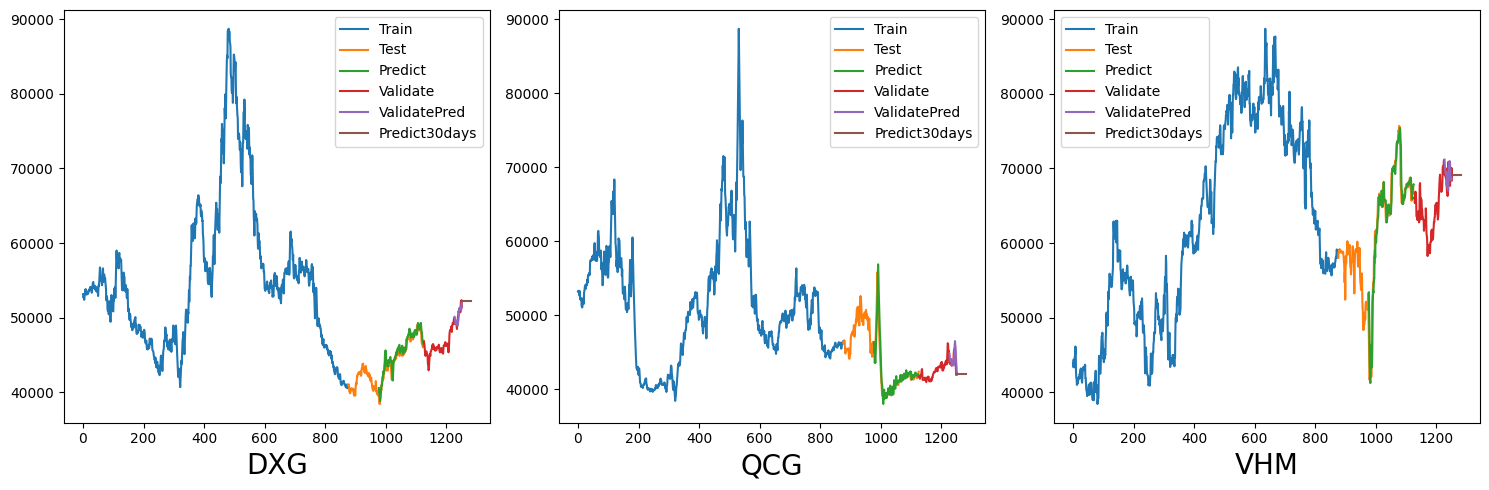

In [16]:
# 14.Vẽ hình
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#DXG
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
axs[0].plot(scaler.inverse_transform(dxg_train_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
axs[0].plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size+101, stop=dxg_train_size+dxg_test_size, step=1)
axs[0].plot(dxg_test_data_index,(dxg_y_pred))
dxg_val_data_index = pd.RangeIndex(start=dxg_train_size+dxg_test_size, stop=dxg_train_size+dxg_test_size+dxg_val_size, step=1)
axs[0].plot(dxg_val_data_index,scaler.inverse_transform(dxg_val_data))
dxg_val_data_index = pd.RangeIndex(start=dxg_train_size+dxg_test_size+101, stop=dxg_train_size+dxg_test_size+dxg_val_size, step=1)
axs[0].plot(dxg_val_data_index,dxg_y_pred_val)
dxg_predict_data_index = pd.RangeIndex(start=len(dxg1)-1, stop=len(dxg1)+29, step=1)
axs[0].plot(dxg_predict_data_index,scaler.inverse_transform(dxg_lst_output))
axs[0].legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])


#QCG
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
axs[1].plot(scaler.inverse_transform(qcg_train_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
axs[1].plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size+101, stop=qcg_train_size+qcg_test_size, step=1)
axs[1].plot(qcg_test_data_index,(qcg_y_pred))
qcg_val_data_index = pd.RangeIndex(start=qcg_train_size+qcg_test_size, stop=qcg_train_size+qcg_test_size+qcg_val_size, step=1)
axs[1].plot(qcg_val_data_index,scaler.inverse_transform(qcg_val_data))
qcg_val_data_index = pd.RangeIndex(start=qcg_train_size+qcg_test_size+101, stop=qcg_train_size+qcg_test_size+qcg_val_size, step=1)
axs[1].plot(qcg_val_data_index,qcg_y_pred_val)
qcg_predict_data_index = pd.RangeIndex(start=len(qcg1)-1, stop=len(qcg1)+29, step=1)
axs[1].plot(qcg_predict_data_index,scaler.inverse_transform(qcg_lst_output))
axs[1].legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])

#VHM
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
axs[2].plot(scaler.inverse_transform(vhm_train_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
axs[2].plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size+101, stop=vhm_train_size+vhm_test_size, step=1)
axs[2].plot(vhm_test_data_index,(vhm_y_pred))
vhm_val_data_index = pd.RangeIndex(start=vhm_train_size+vhm_test_size, stop=vhm_train_size+vhm_test_size+vhm_val_size, step=1)
axs[2].plot(vhm_val_data_index,scaler.inverse_transform(vhm_val_data))
vhm_val_data_index = pd.RangeIndex(start=vhm_train_size+vhm_test_size+101, stop=vhm_train_size+vhm_test_size+vhm_val_size, step=1)
axs[2].plot(vhm_val_data_index,vhm_y_pred_val)
vhm_predict_data_index = pd.RangeIndex(start=len(vhm1)-1, stop=len(vhm1)+29, step=1)
axs[2].plot(vhm_predict_data_index,scaler.inverse_transform(vhm_lst_output))
axs[2].legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])


axs[0].set_xlabel('DXG',fontsize=20)
axs[1].set_xlabel('QCG',fontsize=20)
axs[2].set_xlabel('VHM',fontsize=20)
plt.tight_layout()
plt.show()